### Imports

In [4]:
import itertools

import numpy as np
import collections
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

#### Seed for Reproducibility

In [5]:
np.random.seed(42069)

#### Matplotlib Plot Style

In [6]:
# dark
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# light
# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

### Load RWC Dict

In [7]:
# Load the RWC Dict Pickle File using NumPy
rwc_file_path = "avg_baseline_resnet_18.pkl"

rwc_dict = np.load(rwc_file_path, allow_pickle=True)

##### Remove the initial `conv1.weight` and last `linear.weight` layer

In [8]:
del rwc_dict[next(iter(rwc_dict))]
del rwc_dict[list(rwc_dict.keys())[-1]]
print(f"Number of layers/samples: {len(rwc_dict.keys())}")

Number of layers/samples: 19


### Replace Outliers
Here we are using the following strategy.

- Take the mean of the data for each layer
- Take the Standard Deviation of the data for each layer
- Subtract each data point from the mean of the data and take the absolute of the value
- If the value is greater than 2*(standard deviation), then we replace the value with the mean of the data

In [9]:
def replace_outliers(data, m=2):
    mean_data = np.mean(data)
    standard_dev = np.std(data)
    
    deviation_arr = abs(data - mean_data)
    bounds = m * standard_dev
    
    for index, deviation in enumerate(deviation_arr):
        if deviation > bounds:
            prev_next_avg = mean_data
            data[index] = prev_next_avg
    return data

In [10]:
for key, value in rwc_dict.items():
    updated_values = replace_outliers(value)
    rwc_dict[key] = updated_values

### Plot the RWC Curve

Number of features: 200


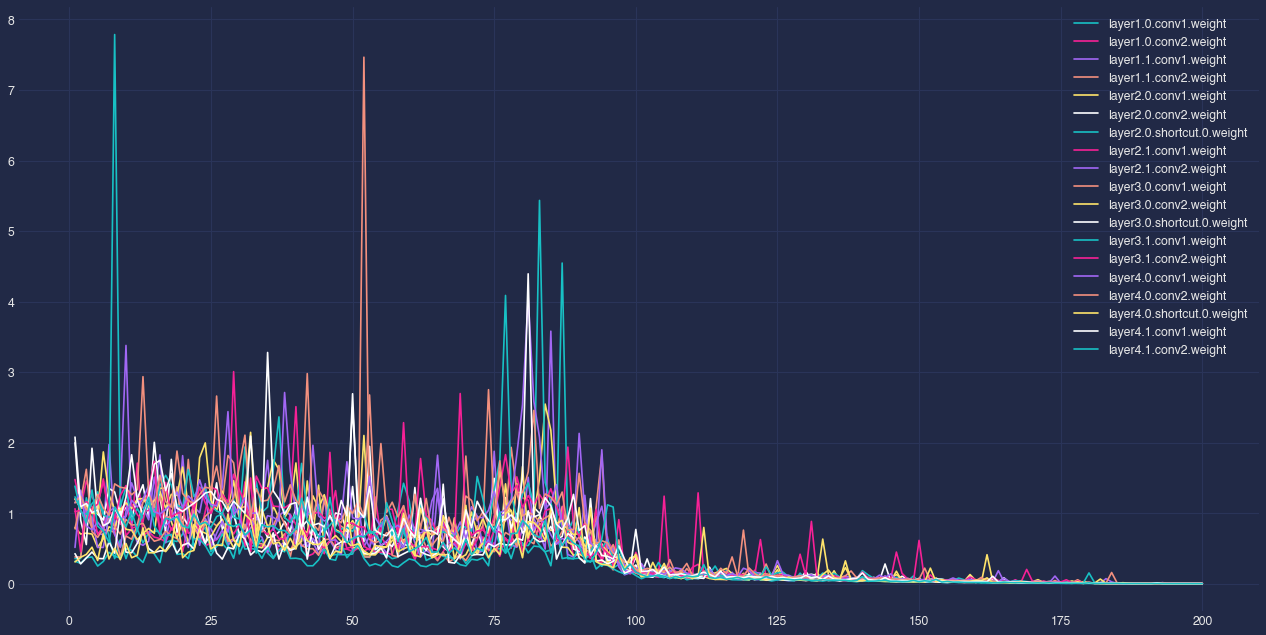

In [11]:
# Get the number of Features
features = len(rwc_dict[next(iter(rwc_dict))])
features_arr = np.arange(1,features+1)
print(f"Number of features: {len(features_arr)}")

fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(111)

for key, value in rwc_dict.items():
    line, = ax.plot(features_arr, value, linestyle = '-')
    line.set_label(key)
    ax.legend()

plt.show()

### Define a matrix of RWC Dict with shape `(layers, epochs)` or `(samples, features)`

In [12]:
# define a matrix using RWC Dict with the shape (samples, features)
rwc_matrix = []
for key, value in rwc_dict.items():
    rwc_matrix.append(value)
    
rwc_matrix = np.array(rwc_matrix)

print(f"KMeans Array Shape: {rwc_matrix.shape}")

KMeans Array Shape: (19, 200)


### KMeans and Average Intra Cluster Distance

In [13]:
def kmeans_and_scree_plot(data: list, K_range: list, n_init: int, max_iter: int):
    """
    Function runs KMeans++ on a range of k values and plots the Average Intra Cluster Distance
    Args:
        data (list): NumPy data to run KMeans on
        n_init (int): Number of different random inits for centroids
        max_iter (int): Maximum number of iterations for the KMeans algorithm
    """
    sum_squared_errors = {}
    for K in K_range:
        kmeans = KMeans(init="k-means++", n_clusters=K, n_init=n_init, max_iter=max_iter)
        kmeans.fit(data)
        sum_squared_errors[K] = kmeans.inertia_
        
    plt.figure()
    plt.plot(list(sum_squared_errors.keys()), list(sum_squared_errors.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    
    return plt
    

#### KMeans on the Original Dataset

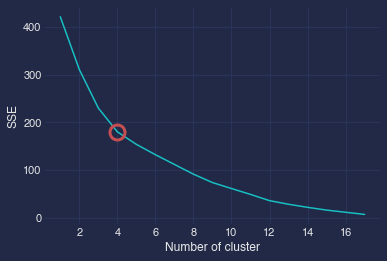

In [14]:
K = np.arange(1, 18)
plt = kmeans_and_scree_plot(data=rwc_matrix, K_range=K, n_init=10, max_iter=300)
plt.plot(4, 180, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
plt.show()
plt.show()

#### Using PCA to reduce dimensions in the data then running KMeans

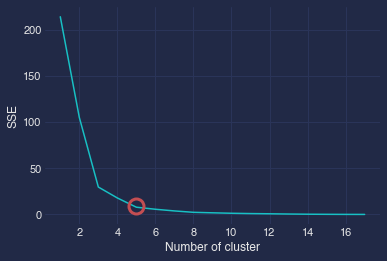

In [15]:
# running KMeans on Reduced Data
reduced_data = PCA(n_components=2).fit_transform(rwc_matrix)
plt = kmeans_and_scree_plot(data=reduced_data, K_range=K, n_init=10, max_iter=300)
plt.plot(5, 9, 'ro', markersize=15, markerfacecolor="none", markeredgewidth=3.0)
plt.show()

### Visualize Data
Here we will perform dimensionality reduction using PCA and then plot the clusters with their respective centroids for the best KMeans on the reduced data

In [16]:
ideal_n_clusters = 5
init = 10
max_it = 300

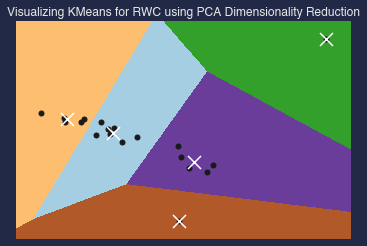

In [17]:
reduced_data = PCA(n_components=2).fit_transform(rwc_matrix)
kmeans = KMeans(init="k-means++", n_clusters=ideal_n_clusters, n_init=init, max_iter=max_it)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=10)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("Visualizing KMeans for RWC using PCA Dimensionality Reduction")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()


### List Layers in Each Cluster

In [18]:
labels_kmeans = kmeans.predict(reduced_data)
rwc_layers_keys = np.asarray(list(rwc_dict.keys()))

clusters_dict = {}
for label, key in zip(labels_kmeans, rwc_layers_keys):
    if not label in clusters_dict:
        clusters_dict[label] = [key]
    else:
        clusters_dict[label].append(key)

clusters_dict = collections.OrderedDict(sorted(clusters_dict.items()))

In [19]:
for key, value in clusters_dict.items():
    label = "\033[1m" + f"Cluster {key}:" + "\033[0m"
    print(f"{label}\n")
    print(f"Centroid Coordinates: ({round(float(centroids[key][0]),4)}, {round(float(centroids[key][1]),4)})\n")
    keys_str = ", ".join(value)
    print(keys_str)
    print("\n-----------------\n")

Cluster 0:

Centroid Coordinates: (-0.9737, 0.216)

layer1.0.conv2.weight, layer1.1.conv1.weight, layer2.0.conv1.weight, layer2.0.conv2.weight, layer2.1.conv1.weight, layer2.1.conv2.weight, layer4.1.conv2.weight

-----------------

Cluster 1:

Centroid Coordinates: (7.6991, 5.5797)

layer3.1.conv1.weight

-----------------

Cluster 2:

Centroid Coordinates: (-2.8273, 1.0067)

layer1.0.conv1.weight, layer1.1.conv2.weight, layer2.0.shortcut.0.weight, layer3.0.shortcut.0.weight, layer4.0.shortcut.0.weight

-----------------

Cluster 3:

Centroid Coordinates: (2.308, -1.4521)

layer3.0.conv2.weight, layer3.1.conv2.weight, layer4.0.conv1.weight, layer4.0.conv2.weight, layer4.1.conv1.weight

-----------------

Cluster 4:

Centroid Coordinates: (1.7133, -4.865)

layer3.0.conv1.weight

-----------------



#### Plot RWC Curve again with the KMeans Clusters

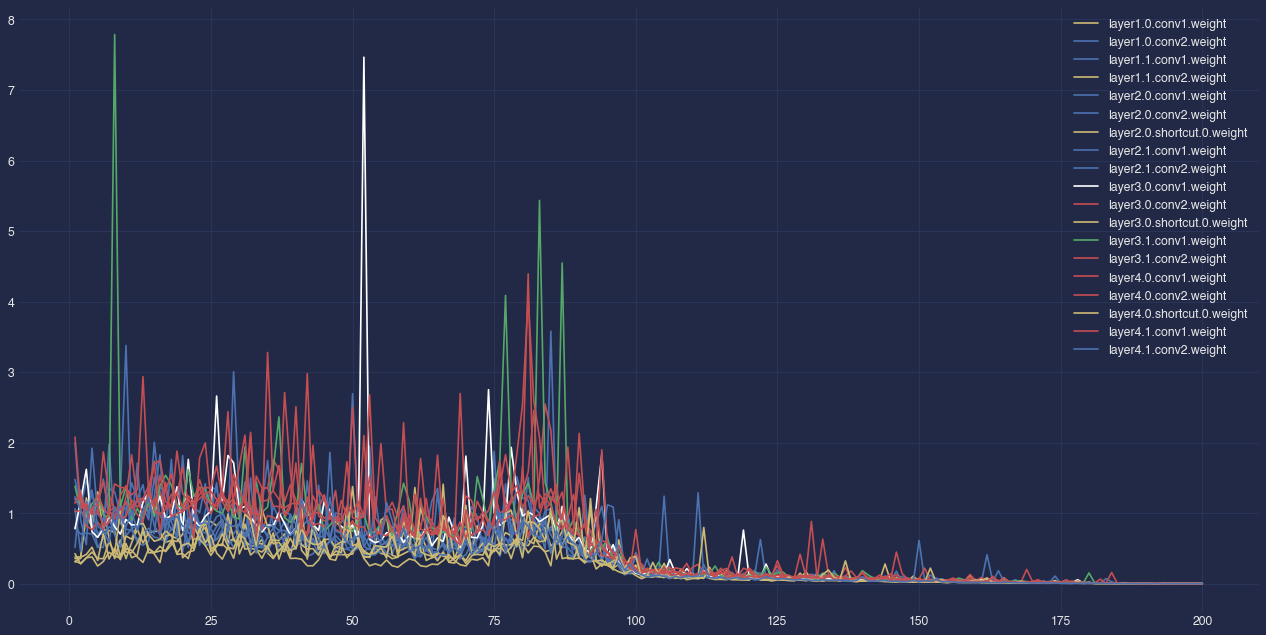

In [20]:
fig = plt.figure(figsize=(20, 10), dpi=80)
ax = fig.add_subplot(111)
kmeans_labels = kmeans.labels_
colors = ['b', 'g', 'y', 'r', 'w', 'm','c']
count = 0

for key, value in rwc_dict.items():
    line, = ax.plot(features_arr, value, linestyle = '-', color=colors[kmeans_labels[count]])
    line.set_label(key)
    ax.legend()
    count += 1

plt.show()

***
# Questions

- Is KMeans the right clustering algorithm? 
- If yes, how to we split the epochs as clustering over 200 epochs seem tricky
- What do we do about the outliers in RWC? Do we keep them or remove them?
- If this doesn't connect with our previous visualization, then how do we justify which is right?
- Do we solely focus on learning layers (conv layers, skip connections) or include other things like (maxpool, ReLU)

#### Why do we have outliers? How do they impact training? 

> Can we update the RWC Metric to remove outliers during training? Or can RWC be updated to avoid outliers altogether?



















***
# Other Clustering Algorithms

### <u>KMedian</u>
Similar to KMeans with the only difference being that instead of calculating the Mean of the data, you calculate the Median. This <b>works better</b> in the cases where outliers are present.

### <u>Mean-Shift Clustering</u>
Sliding Window Approach based clustering
Finds Dense points in the data
Centroud based algorithm

<font color="green">**Pros**</font>
- No need to select the number of clusters. Found automatically
- Cluster centers converge towards areas of maximum density

<font color="red">**Cons**</font>
- The sliding window size can be non-trivial

### <u>DBSCAN</u>
Density based clustering algorithm
Similar to Mean-Shift but better in certain ways

<font color="green">**Pros**</font>
- No need to select the number of clusters. Found automatically
- Labels points with less neighbors as **noise**. 
> This is particularly interesting to me because why are we assuming that a certain architecture needs all the layers that are currently in it. Maybe we don't need certain layers.
- Can find arbitrarily sized clusters quite well

<font color="red">**Cons**</font>
- Doesn't perform as well when clusters are of varying density
> Happens because the distance threshold (epsilon) and minimum points to identify neighbor points vary from cluster to cluster
- Causes the same above issue with high dimension data. <font color="brown">(This is sad)</font>

### <u>Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)</u>
Assume that the data distribution is Gaussian. Then run Expectation Maximization algorithm using two parameters **(mean and standard deviation)**. The closer the point is to the Gaussian center, the more likely it is to be in the cluster.

<font color="green">**Pros**</font>
- More flexible than KMeans in terms of cluster covariance because of the **standard deviation** parameter.
- Clusters can take elliptical shape rather than being limited to circles
- KMeans is a special case of GMM
- A single data point can have multiple clusters. <font color="brown">(Is this useful?)</font>

<font color="red">**Cons**</font>
- Don't know yet

### <u>Agglomerative Hierarchical Clustering</u>
Heirarchical bottom-up clustering algorithm. Start by treating each data point as a single cluster and then successively merge pairs of clusters until all of them have been merged into a single cluster.

<font color="green">**Pros**</font>
- Does not require to specify the number of clusters
- Algorithm is not sensitive to distance metric

<font color="red">**Cons**</font>
- $O(n^3)$ time complexity